In [1]:
import cuml
import cudf
import os
import time

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

In [44]:
from scipy.spatial.distance import cdist
import cupy as cp

In [4]:
# from cuml import DBSCAN as cumlDBSCAN
from cuml.dask.cluster.kmeans import KMeans as daskKMeans
from cuml.decomposition import PCA
import cupy

from dask_cuda import LocalCUDACluster
import dask_cudf
from dask.distributed import Client
import dask.dataframe as dd

from cuml.dask.cluster.dbscan import DBSCAN as daskDBSCAN
# from dask_cuml.cluster import DBSCAN as daskDBSCAN

In [5]:
!python --version

Python 3.7.10


In [6]:
!pwd

/rapids/notebooks/host/transformer_attention_clustering/clustering


In [7]:
output_dir='/rapids/notebooks/host/representations/output/'

In [8]:
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0,1")
client = Client(cluster)

In [9]:
# note - using 'file://' prefix: https://github.com/rapidsai/cudf/issues/3017
gdf = dask_cudf.read_csv('file://../../representations/final/partitions/*.csv')

In [33]:
%%time
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(5,65,10)
 
for k in K:
    kmeanModel = daskKMeans(
                       client=client,
                       init="k-means||",
                       n_clusters=k,
                       random_state=42).fit(gdf)
#     kmeanModel.fit(gdf)
    pd_cluster_centers_ = kmeanModel.cluster_centers_.to_pandas()
    
    distortions.append(sum(np.min(cdist(pd_gdf, pd_cluster_centers_,
                                        'euclidean'), axis=1)) / pd_gdf.shape[0])
    inertia = kmeanModel.score(gdf)
    inertias.append(inertia)
    
    mapping1[k] = sum(np.min(cdist(pd_gdf, pd_cluster_centers_,
                                   'euclidean'), axis=1)) / pd_gdf.shape[0]
    mapping2[k] = inertia

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 4min 18s, sys: 14.7 s, total: 4min 33s
Wall time: 29min 27s


In [34]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

5 : 0.6726213585802026
15 : 0.6455843984405876
25 : 0.634506696500513
35 : 0.6264223951615014
45 : 0.6216402685972963
55 : 0.6173748718406


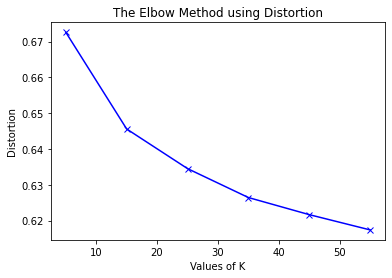

In [35]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [36]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

5 : -138408.59337178073
15 : -127692.9946580579
25 : -123334.67067136135
35 : -120263.77317249098
45 : -118406.1857191003
55 : -116873.21126706469


In [46]:
np_inertias = cp.asarray(inertias)

In [49]:
np_inertias = cp.asnumpy(np_inertias)

In [50]:
type(np_inertias)

numpy.ndarray

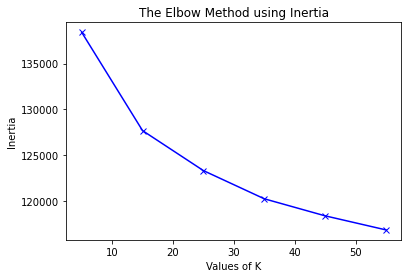

In [52]:
plt.plot(K, abs(np_inertias), 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()